# Spherical Fourier-Bessel Turbulence Driving Test

This notebook provides tools to test and visualize the Spherical Fourier-Bessel (SFB) turbulence driving implementation.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import spherical_jn, lpmv
from scipy.optimize import brentq
import ipywidgets as widgets
from IPython.display import display
from numba import njit, prange
import math

## 1. Spherical Bessel Function Utilities

In [15]:
def find_spherical_bessel_root(l, n):
    """
    Find the n-th root of the spherical Bessel function j_l(x)
    """
    # Initial guess
    if n == 1 and l == 0:
        x0 = np.pi
    elif n == 1 and l == 1:
        x0 = 4.49341
    elif n == 1 and l == 2:
        x0 = 5.76346
    else:
        x0 = (n + 0.5*l - 0.25) * np.pi
    
    # Search interval
    dx = 0.5
    x1 = x0 - dx
    x2 = x0 + dx
    
    # Make sure we bracket the root
    max_iter = 20
    iter_count = 0
    while spherical_jn(l, x1) * spherical_jn(l, x2) > 0 and iter_count < max_iter:
        dx *= 1.5
        x1 = x0 - dx
        x2 = x0 + dx
        iter_count += 1
    
    if iter_count >= max_iter:
        print(f"Warning: Could not bracket root for l={l}, n={n}")
        return x0
    
    # Find root using Brent's method
    try:
        root = brentq(lambda x: spherical_jn(l, x), x1, x2)
        return root
    except:
        print(f"Warning: Brent's method failed for l={l}, n={n}")
        return x0

def spherical_jn_derivative(l, x):
    """
    Derivative of spherical Bessel function
    """
    if x == 0:
        return 1.0/3.0 if l == 1 else 0.0
    if l == 0:
        return -spherical_jn(1, x)
    return spherical_jn(l-1, x) - (l+1)/x * spherical_jn(l, x)

In [16]:
# Numba-accelerated functions for spherical Bessel functions and harmonics
@njit
def spherical_jn_numba(n, z):
    """Spherical Bessel function of the first kind - Numba version"""
    if abs(z) < 1e-10:
        return 1.0 if n == 0 else 0.0
    
    if n == 0:
        return np.sin(z) / z
    elif n == 1:
        return np.sin(z) / (z * z) - np.cos(z) / z
    else:
        # Use recurrence relation
        jnm2 = np.sin(z) / z
        jnm1 = np.sin(z) / (z * z) - np.cos(z) / z
        for i in range(2, n + 1):
            jn = (2 * i - 1) / z * jnm1 - jnm2
            jnm2 = jnm1
            jnm1 = jn
        return jnm1

@njit
def spherical_jn_derivative_numba(n, z):
    """Derivative of spherical Bessel function - Numba version"""
    if z == 0:
        return 1.0/3.0 if n == 1 else 0.0
    if n == 0:
        return -spherical_jn_numba(1, z)
    return spherical_jn_numba(n-1, z) - (n+1)/z * spherical_jn_numba(n, z)

@njit
def factorial_numba(n):
    """Factorial function for Numba"""
    if n < 0:
        return 0
    result = 1
    for i in range(2, n + 1):
        result *= i
    return result

@njit
def legendre_Plm_numba(l, m, x):
    """Associated Legendre polynomial - Numba version"""
    m = abs(m)
    
    # Compute P_m^m
    pmm = 1.0
    if m > 0:
        somx2 = np.sqrt((1.0 - x) * (1.0 + x))
        fact = 1.0
        for i in range(1, m + 1):
            pmm *= -fact * somx2
            fact += 2.0
    
    if l == m:
        return pmm
    
    # Compute P_{m+1}^m
    pmmp1 = x * (2.0 * m + 1.0) * pmm
    if l == m + 1:
        return pmmp1
    
    # Upward recurrence
    pll = 0.0
    for ll in range(m + 2, l + 1):
        pll = ((2.0 * ll - 1.0) * x * pmmp1 - (ll + m - 1.0) * pmm) / (ll - m)
        pmm = pmmp1
        pmmp1 = pll
    
    return pll

@njit
def spherical_harmonic_numba(l, m, theta, phi):
    """Real spherical harmonic - Numba version"""
    # Normalization factor
    norm = np.sqrt((2 * l + 1) / (4 * np.pi) * 
                   factorial_numba(l - abs(m)) / factorial_numba(l + abs(m)))
    
    # Associated Legendre polynomial
    Plm = legendre_Plm_numba(l, abs(m), np.cos(theta))
    
    # Real spherical harmonic
    if m >= 0:
        Ylm = norm * Plm * np.cos(m * phi)
    else:
        Ylm = norm * Plm * np.sin(abs(m) * phi)
    
    return Ylm

@njit
def vector_spherical_harmonic_B_numba(l, m, r, theta, phi, kln):
    """Compute magnetic-type vector spherical harmonic - Numba version"""
    # Compute jl and its derivative
    kr = kln * r
    jl = spherical_jn_numba(l, kr) if r > 0 else (1.0 if l == 0 else 0.0)
    jl_prime = spherical_jn_derivative_numba(l, kr) if r > 0 else 0.0
    
    # Compute Ylm
    Ylm = spherical_harmonic_numba(l, m, theta, phi)
    
    # Gradient components in spherical coordinates
    djl_dr = kln * jl_prime
    
    # For derivatives of Ylm, we need more careful calculation
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    # Gradient of jl*Ylm in spherical coordinates
    grad_r = djl_dr * Ylm
    
    # Numerical derivatives for theta and phi
    dtheta = 1e-6
    dphi = 1e-6
    
    if sin_theta > 1e-10:
        Ylm_plus_theta = spherical_harmonic_numba(l, m, theta + dtheta, phi)
        Ylm_minus_theta = spherical_harmonic_numba(l, m, theta - dtheta, phi)
        grad_theta = jl/r * (Ylm_plus_theta - Ylm_minus_theta) / (2*dtheta)
        
        Ylm_plus_phi = spherical_harmonic_numba(l, m, theta, phi + dphi)
        Ylm_minus_phi = spherical_harmonic_numba(l, m, theta, phi - dphi)
        grad_phi = jl/(r*sin_theta) * (Ylm_plus_phi - Ylm_minus_phi) / (2*dphi)
    else:
        grad_theta = 0.0
        grad_phi = 0.0
    
    # Cross product with r_hat gives B_lm in spherical coordinates
    Br = 0.0
    Btheta = -grad_phi
    Bphi = grad_theta
    
    # Convert to Cartesian coordinates
    sin_phi = np.sin(phi)
    cos_phi = np.cos(phi)
    
    Bx = (Br * sin_theta * cos_phi + 
          Btheta * cos_theta * cos_phi - 
          Bphi * sin_phi)
    By = (Br * sin_theta * sin_phi + 
          Btheta * cos_theta * sin_phi + 
          Bphi * cos_phi)
    Bz = (Br * cos_theta - 
          Btheta * sin_theta)
    
    return Bx, By, Bz

In [ ]:
@njit
def spherical_jn_numba(n, z):
    """Spherical Bessel function of the first kind - Numba version"""
    if abs(z) < 1e-10:
        return 1.0 if n == 0 else 0.0
    
    if n == 0:
        return np.sin(z) / z
    elif n == 1:
        return np.sin(z) / (z * z) - np.cos(z) / z
    else:
        # Use recurrence relation
        jnm2 = np.sin(z) / z
        jnm1 = np.sin(z) / (z * z) - np.cos(z) / z
        for i in range(2, n + 1):
            jn = (2 * i - 1) / z * jnm1 - jnm2
            jnm2 = jnm1
            jnm1 = jn
        return jnm1

@njit
def spherical_jn_derivative_numba(n, z):
    """Derivative of spherical Bessel function - Numba version"""
    if abs(z) < 1e-10:
        if n == 0:
            return 0.0
        elif n == 1:
            return 1.0/3.0
        else:
            return 0.0
    if n == 0:
        return -spherical_jn_numba(1, z)
    return spherical_jn_numba(n-1, z) - (n+1)/z * spherical_jn_numba(n, z)

@njit
def factorial_numba(n):
    """Factorial function for Numba"""
    if n < 0:
        return 0
    result = 1
    for i in range(2, n + 1):
        result *= i
    return result

@njit
def legendre_Plm_numba(l, m, x):
    """Associated Legendre polynomial - Numba version"""
    m = abs(m)
    
    # Compute P_m^m
    pmm = 1.0
    if m > 0:
        somx2 = np.sqrt((1.0 - x) * (1.0 + x))
        fact = 1.0
        for i in range(1, m + 1):
            pmm *= -fact * somx2
            fact += 2.0
    
    if l == m:
        return pmm
    
    # Compute P_{m+1}^m
    pmmp1 = x * (2.0 * m + 1.0) * pmm
    if l == m + 1:
        return pmmp1
    
    # Upward recurrence
    pll = 0.0
    for ll in range(m + 2, l + 1):
        pll = ((2.0 * ll - 1.0) * x * pmmp1 - (ll + m - 1.0) * pmm) / (ll - m)
        pmm = pmmp1
        pmmp1 = pll
    
    return pll

@njit
def spherical_harmonic_numba(l, m, theta, phi):
    """Real spherical harmonic - Numba version"""
    # Normalization factor
    norm = np.sqrt((2 * l + 1) / (4 * np.pi) * 
                   factorial_numba(l - abs(m)) / factorial_numba(l + abs(m)))
    
    # Associated Legendre polynomial
    Plm = legendre_Plm_numba(l, abs(m), np.cos(theta))
    
    # Real spherical harmonic
    if m >= 0:
        Ylm = norm * Plm * np.cos(m * phi)
    else:
        Ylm = norm * Plm * np.sin(abs(m) * phi)
    
    return Ylm

@njit
def vector_spherical_harmonic_B_numba(l, m, r, theta, phi, kln, r_min=0.01):
    """
    Compute magnetic-type vector spherical harmonic - Numba version
    with regularization near r=0
    """
    # Regularize near origin
    if r < r_min:
        # Use Taylor series expansion near r=0
        # For l=1, the leading behavior is linear in r
        # For higher l, it goes as r^l
        if l == 0:
            return 0.0, 0.0, 0.0
        elif l == 1:
            # Linear approximation for l=1
            factor = kln * r / 3.0  # j_1(kr) ~ kr/3 for small kr
            Ylm = spherical_harmonic_numba(l, m, theta, phi)
            # Simple approximation for the vector components
            return factor * Ylm * np.sin(theta) * np.cos(phi), \
                   factor * Ylm * np.sin(theta) * np.sin(phi), \
                   factor * Ylm * np.cos(theta)
        else:
            # Higher order modes are suppressed near origin
            return 0.0, 0.0, 0.0
    
    # Normal computation for r > r_min
    kr = kln * r
    jl = spherical_jn_numba(l, kr)
    jl_prime = spherical_jn_derivative_numba(l, kr)
    
    # Compute Ylm
    Ylm = spherical_harmonic_numba(l, m, theta, phi)
    
    # Gradient components in spherical coordinates
    djl_dr = kln * jl_prime
    
    # For derivatives of Ylm, we need more careful calculation
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    # Avoid singularity at poles
    if sin_theta < 1e-10:
        return 0.0, 0.0, 0.0
    
    # Gradient of jl*Ylm in spherical coordinates
    grad_r = djl_dr * Ylm
    
    # Numerical derivatives for theta and phi
    dtheta = 1e-6
    dphi = 1e-6
    
    Ylm_plus_theta = spherical_harmonic_numba(l, m, theta + dtheta, phi)
    Ylm_minus_theta = spherical_harmonic_numba(l, m, theta - dtheta, phi)
    grad_theta = jl/r * (Ylm_plus_theta - Ylm_minus_theta) / (2*dtheta)
    
    Ylm_plus_phi = spherical_harmonic_numba(l, m, theta, phi + dphi)
    Ylm_minus_phi = spherical_harmonic_numba(l, m, theta, phi - dphi)
    grad_phi = jl/(r*sin_theta) * (Ylm_plus_phi - Ylm_minus_phi) / (2*dphi)
    
    # Cross product with r_hat gives B_lm in spherical coordinates
    Br = 0.0
    Btheta = -grad_phi
    Bphi = grad_theta
    
    # Convert to Cartesian coordinates
    sin_phi = np.sin(phi)
    cos_phi = np.cos(phi)
    
    Bx = (Br * sin_theta * cos_phi + 
          Btheta * cos_theta * cos_phi - 
          Bphi * sin_phi)
    By = (Br * sin_theta * sin_phi + 
          Btheta * cos_theta * sin_phi + 
          Bphi * cos_phi)
    Bz = (Br * cos_theta - 
          Btheta * sin_theta)
    
    return Bx, By, Bz

## 2. Spherical Harmonics Utilities

In [18]:
def spherical_harmonic(l, m, theta, phi):
    """
    Compute real spherical harmonic Y_lm(theta, phi)
    """
    # Normalization factor
    import math
    norm = np.sqrt((2*l + 1) / (4*np.pi) * 
                   math.factorial(l - abs(m)) / math.factorial(l + abs(m)))
    
    # Associated Legendre polynomial
    Plm = lpmv(abs(m), l, np.cos(theta))
    
    # Real spherical harmonic
    if m >= 0:
        Ylm = norm * Plm * np.cos(m * phi)
    else:
        Ylm = norm * Plm * np.sin(abs(m) * phi)
    
    return Ylm

def vector_spherical_harmonic_B(l, m, r, theta, phi, kln):
    """
    Compute magnetic-type vector spherical harmonic B_lm = curl(r * jl * Ylm)
    Returns components in Cartesian coordinates
    """
    # Compute jl and its derivative
    kr = kln * r
    jl = spherical_jn(l, kr) if r > 0 else (1.0 if l == 0 else 0.0)
    jl_prime = spherical_jn_derivative(l, kr) if r > 0 else 0.0
    
    # Compute Ylm and its derivatives
    Ylm = spherical_harmonic(l, m, theta, phi)
    
    # Gradient components in spherical coordinates
    djl_dr = kln * jl_prime
    
    # For derivatives of Ylm, we need more careful calculation
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    
    # Gradient of jl*Ylm in spherical coordinates
    grad_r = djl_dr * Ylm
    
    # For simplicity, compute numerical derivatives for theta and phi
    dtheta = 1e-6
    dphi = 1e-6
    
    if sin_theta > 1e-10:
        Ylm_plus_theta = spherical_harmonic(l, m, theta + dtheta, phi)
        Ylm_minus_theta = spherical_harmonic(l, m, theta - dtheta, phi)
        grad_theta = jl/r * (Ylm_plus_theta - Ylm_minus_theta) / (2*dtheta)
        
        Ylm_plus_phi = spherical_harmonic(l, m, theta, phi + dphi)
        Ylm_minus_phi = spherical_harmonic(l, m, theta, phi - dphi)
        grad_phi = jl/(r*sin_theta) * (Ylm_plus_phi - Ylm_minus_phi) / (2*dphi)
    else:
        grad_theta = 0.0
        grad_phi = 0.0
    
    # Cross product with r_hat gives B_lm in spherical coordinates
    Br = 0.0
    Btheta = -grad_phi
    Bphi = grad_theta
    
    # Convert to Cartesian coordinates
    sin_phi = np.sin(phi)
    cos_phi = np.cos(phi)
    
    Bx = (Br * sin_theta * cos_phi + 
          Btheta * cos_theta * cos_phi - 
          Bphi * sin_phi)
    By = (Br * sin_theta * sin_phi + 
          Btheta * cos_theta * sin_phi + 
          Bphi * cos_phi)
    Bz = (Br * cos_theta - 
          Btheta * sin_theta)
    
    return np.array([Bx, By, Bz])

## 3. SFB Mode Selection

In [19]:
def select_sfb_modes(lmax, nmax, r0_turb, kmin, kmax):
    """
    Select SFB modes within a given wavenumber range
    """
    modes = []
    
    for l in range(lmax + 1):
        for n in range(1, nmax + 1):
            xln = find_spherical_bessel_root(l, n)
            kln = xln / r0_turb
            
            if kmin <= kln <= kmax:
                for m in range(-l, l + 1):
                    modes.append({
                        'l': l, 'm': m, 'n': n,
                        'xln': xln, 'kln': kln
                    })
    
    return modes

# Test mode selection
lmax = 10
nmax = 5
r0_turb = 0.4
kmin = 2 * 2*np.pi  # nlow * fundamental wavenumber
kmax = 8 * 2*np.pi  # nhigh * fundamental wavenumber

modes = select_sfb_modes(lmax, nmax, r0_turb, kmin, kmax)
print(f"Selected {len(modes)} modes with k in [{kmin:.2f}, {kmax:.2f}]")
print("\nFirst 10 modes:")
for i, mode in enumerate(modes[:10]):
    print(f"Mode {i}: l={mode['l']}, m={mode['m']:+2d}, n={mode['n']}, k={mode['kln']:.3f}")

Selected 290 modes with k in [12.57, 50.27]

First 10 modes:
Mode 0: l=0, m=+0, n=2, k=15.708
Mode 1: l=0, m=+0, n=3, k=23.562
Mode 2: l=0, m=+0, n=4, k=31.416
Mode 3: l=0, m=+0, n=5, k=39.270
Mode 4: l=1, m=-1, n=2, k=19.313
Mode 5: l=1, m=+0, n=2, k=19.313
Mode 6: l=1, m=+1, n=2, k=19.313
Mode 7: l=1, m=-1, n=3, k=27.260
Mode 8: l=1, m=+0, n=3, k=27.260
Mode 9: l=1, m=+1, n=3, k=27.260


In [ ]:
@njit(parallel=True)
def compute_sfb_field_fast(X, Y, Z, vx, vy, vz, modes_l, modes_m, modes_kln, amplitudes, r0_turb, r_min=0.01):
    """
    Fast computation of SFB field using Numba parallel acceleration
    with regularization near r=0
    """
    nx, ny, nz = X.shape
    n_modes = len(modes_l)
    
    # Loop over grid points in parallel
    for i in prange(nx):
        for j in range(ny):
            for k in range(nz):
                x = X[i, j, k]
                y = Y[i, j, k]
                z = Z[i, j, k]
                
                r = np.sqrt(x*x + y*y + z*z)
                
                # Skip points outside r0_turb
                if r >= r0_turb:
                    vx[i, j, k] = 0.0
                    vy[i, j, k] = 0.0
                    vz[i, j, k] = 0.0
                    continue
                
                # Handle origin specially
                if r < r_min:
                    # Near origin, use regularized version
                    theta = 0.0  # Arbitrary at origin
                    phi = 0.0
                else:
                    # Convert to spherical coordinates
                    theta = np.arccos(z / r)
                    phi = np.arctan2(y, x)
                
                # Sum contributions from all modes
                vx_sum = 0.0
                vy_sum = 0.0
                vz_sum = 0.0
                
                for mode_idx in range(n_modes):
                    l = modes_l[mode_idx]
                    m = modes_m[mode_idx]
                    kln = modes_kln[mode_idx]
                    
                    # Get vector spherical harmonic with regularization
                    Bx, By, Bz = vector_spherical_harmonic_B_numba(l, m, r, theta, phi, kln, r_min)
                    
                    # Add contribution with amplitude
                    vx_sum += amplitudes[mode_idx, 0] * Bx
                    vy_sum += amplitudes[mode_idx, 1] * By
                    vz_sum += amplitudes[mode_idx, 2] * Bz
                
                vx[i, j, k] = vx_sum
                vy[i, j, k] = vy_sum
                vz[i, j, k] = vz_sum

def remove_net_momentum_and_normalize(vx, vy, vz, r0_turb, X, Y, Z):
    """
    Remove net momentum and normalize velocity field to zero mean and unit variance
    """
    # Create mask for points inside r0_turb
    R = np.sqrt(X**2 + Y**2 + Z**2)
    mask = R < r0_turb
    
    # Calculate mean velocities inside r0_turb
    if np.any(mask):
        vx_mean = np.mean(vx[mask])
        vy_mean = np.mean(vy[mask])
        vz_mean = np.mean(vz[mask])
        
        # Remove mean (ensure zero net momentum)
        vx[mask] -= vx_mean
        vy[mask] -= vy_mean
        vz[mask] -= vz_mean
        
        # Calculate RMS velocity
        vrms = np.sqrt(np.mean(vx[mask]**2 + vy[mask]**2 + vz[mask]**2))
        
        # Normalize to unit variance
        if vrms > 0:
            vx[mask] /= vrms
            vy[mask] /= vrms
            vz[mask] /= vrms
    
    return vx, vy, vz

def generate_sfb_turbulent_field_fast(grid_size=64, r0_turb=0.4, lmax=10, nmax=5, 
                                     kmin=12, kmax=50, expo=5/3, normalize=True,
                                     r_min=None):
    """
    Generate a turbulent velocity field using SFB basis - FAST version
    with momentum removal and normalization
    """
    print(f"Generating {grid_size}^3 grid with SFB turbulence...")
    
    # Set minimum radius based on grid size
    if r_min is None:
        r_min = 2.0 / grid_size  # A few grid cells
    
    # Create grid
    x = np.linspace(-0.5, 0.5, grid_size)
    y = np.linspace(-0.5, 0.5, grid_size)
    z = np.linspace(-0.5, 0.5, grid_size)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    
    # Select modes
    modes = select_sfb_modes(lmax, nmax, r0_turb, kmin, kmax)
    n_modes = len(modes)
    print(f"Using {n_modes} modes")
    
    # Prepare mode arrays for Numba
    modes_l = np.array([mode['l'] for mode in modes], dtype=np.int32)
    modes_m = np.array([mode['m'] for mode in modes], dtype=np.int32)
    modes_kln = np.array([mode['kln'] for mode in modes], dtype=np.float64)
    
    # Generate random amplitudes
    np.random.seed(42)  # For reproducibility
    amplitudes = np.zeros((n_modes, 3), dtype=np.float64)
    
    for i, mode in enumerate(modes):
        kln = mode['kln']
        # Power spectrum normalization
        norm = kln**(-expo/2 - 1) if kln > 0 else 0
        # Random amplitudes
        amplitudes[i, :] = norm * np.random.randn(3)
    
    # Initialize velocity field
    vx = np.zeros_like(X)
    vy = np.zeros_like(Y)
    vz = np.zeros_like(Z)
    
    # Compute field using fast Numba function
    import time
    start_time = time.time()
    compute_sfb_field_fast(X, Y, Z, vx, vy, vz, modes_l, modes_m, modes_kln, amplitudes, r0_turb, r_min)
    
    # Remove net momentum and normalize if requested
    if normalize:
        vx, vy, vz = remove_net_momentum_and_normalize(vx, vy, vz, r0_turb, X, Y, Z)
    
    end_time = time.time()
    print(f"Field generation took {end_time - start_time:.2f} seconds")
    print(f"Regularization radius r_min = {r_min:.4f}")
    
    return X, Y, Z, vx, vy, vz

## 4. Generate SFB Turbulent Field

In [21]:
def generate_sfb_turbulent_field(grid_size=64, r0_turb=0.4, lmax=10, nmax=5, 
                                kmin=12, kmax=50, expo=5/3):
    """
    Generate a turbulent velocity field using SFB basis
    """
    # Create grid
    x = np.linspace(-0.5, 0.5, grid_size)
    y = np.linspace(-0.5, 0.5, grid_size)
    z = np.linspace(-0.5, 0.5, grid_size)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    
    # Convert to spherical coordinates
    R = np.sqrt(X**2 + Y**2 + Z**2)
    Theta = np.arccos(np.where(R > 0, Z/R, 1.0))
    Phi = np.arctan2(Y, X)
    
    # Select modes
    modes = select_sfb_modes(lmax, nmax, r0_turb, kmin, kmax)
    
    # Initialize velocity field
    vx = np.zeros_like(X)
    vy = np.zeros_like(Y)
    vz = np.zeros_like(Z)
    
    # Generate random amplitudes for each mode
    np.random.seed(42)  # For reproducibility
    
    for mode in modes:
        l = mode['l']
        m = mode['m']
        kln = mode['kln']
        
        # Power spectrum normalization
        norm = kln**(-expo/2 - 1) if kln > 0 else 0
        
        # Random amplitudes
        amp = norm * np.random.randn(3)
        
        # Compute vector spherical harmonic at each grid point
        for i in range(grid_size):
            for j in range(grid_size):
                for k in range(grid_size):
                    r = R[i,j,k]
                    if r < r0_turb and r > 0:
                        theta = Theta[i,j,k]
                        phi = Phi[i,j,k]
                        
                        B = vector_spherical_harmonic_B(l, m, r, theta, phi, kln)
                        
                        vx[i,j,k] += amp[0] * B[0]
                        vy[i,j,k] += amp[1] * B[1]
                        vz[i,j,k] += amp[2] * B[2]
    
    return X, Y, Z, vx, vy, vz

## 5. Visualization Tools

def check_divergence(X, Y, Z, vx, vy, vz):
    """
    Check divergence of velocity field
    """
    dx = X[1,0,0] - X[0,0,0]
    dy = Y[0,1,0] - Y[0,0,0]
    dz = Z[0,0,1] - Z[0,0,0]
    
    # Compute divergence using central differences
    dvx_dx = np.gradient(vx, dx, axis=0)
    dvy_dy = np.gradient(vy, dy, axis=1)
    dvz_dz = np.gradient(vz, dz, axis=2)
    
    div = dvx_dx + dvy_dy + dvz_dz
    
    # Get statistics inside r0_turb
    R = np.sqrt(X**2 + Y**2 + Z**2)
    mask = R < 0.4
    
    if np.any(mask):
        div_masked = div[mask]
        print(f"Divergence statistics (inside r0_turb):")
        print(f"  Max |div(v)|: {np.max(np.abs(div_masked)):.6f}")
        print(f"  Mean |div(v)|: {np.mean(np.abs(div_masked)):.6f}")
        print(f"  RMS div(v): {np.sqrt(np.mean(div_masked**2)):.6f}")
    
    return div

def plot_sfb_field_slice(X, Y, Z, vx, vy, vz, slice_z=None):
    """
    Plot slice of the SFB velocity field
    """
    if slice_z is None:
        slice_z = Z.shape[2] // 2
    
    fig = plt.figure(figsize=(15, 5))
    
    # Velocity magnitude
    ax1 = plt.subplot(131)
    vmag_slice = np.sqrt(vx[:,:,slice_z]**2 + vy[:,:,slice_z]**2 + vz[:,:,slice_z]**2)
    im = ax1.contourf(X[:,:,slice_z], Y[:,:,slice_z], vmag_slice, levels=20, cmap='RdBu_r')
    plt.colorbar(im, ax=ax1, label='|v|')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_title(f'Velocity Magnitude (z={Z[0,0,slice_z]:.2f})')
    ax1.set_aspect('equal')
    
    # Draw circle at r0_turb
    circle = plt.Circle((0, 0), 0.4, fill=False, color='black', linewidth=2, linestyle='--')
    ax1.add_patch(circle)
    
    # Velocity vectors
    ax2 = plt.subplot(132)
    skip = max(X.shape[0] // 20, 1)
    ax2.quiver(X[::skip,::skip,slice_z], Y[::skip,::skip,slice_z],
               vx[::skip,::skip,slice_z], vy[::skip,::skip,slice_z],
               alpha=0.7)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Velocity Vectors')
    ax2.set_aspect('equal')
    ax2.set_xlim(-0.5, 0.5)
    ax2.set_ylim(-0.5, 0.5)
    
    # Draw circle
    circle2 = plt.Circle((0, 0), 0.4, fill=False, color='black', linewidth=2, linestyle='--')
    ax2.add_patch(circle2)
    
    # Vorticity
    ax3 = plt.subplot(133)
    dx = X[1,0,0] - X[0,0,0]
    dy = Y[0,1,0] - Y[0,0,0]
    dvy_dx = np.gradient(vy[:,:,slice_z], dx, axis=0)
    dvx_dy = np.gradient(vx[:,:,slice_z], dy, axis=1)
    vorticity = dvy_dx - dvx_dy
    
    im3 = ax3.contourf(X[:,:,slice_z], Y[:,:,slice_z], vorticity, levels=20, cmap='RdBu_r')
    plt.colorbar(im3, ax=ax3, label='ω_z')
    ax3.set_xlabel('x')
    ax3.set_ylabel('y')
    ax3.set_title('Vorticity (z-component)')
    ax3.set_aspect('equal')
    
    # Draw circle
    circle3 = plt.Circle((0, 0), 0.4, fill=False, color='black', linewidth=2, linestyle='--')
    ax3.add_patch(circle3)
    
    plt.tight_layout()
    plt.show()

In [28]:
# Generate SFB turbulent field using FAST version
print("Generating SFB turbulent field with Numba acceleration...")

# First, let's test with a smaller grid to ensure it works
X_small, Y_small, Z_small, vx_small, vy_small, vz_small = generate_sfb_turbulent_field_fast(
    grid_size=32,
    r0_turb=0.4,
    lmax=8,
    nmax=4,
    kmin=12,
    kmax=50,
    expo=5/3
)

print("\nField statistics:")
vmag_small = np.sqrt(vx_small**2 + vy_small**2 + vz_small**2)
print(f"Max velocity magnitude: {np.max(vmag_small):.4f}")
print(f"Mean velocity magnitude: {np.mean(vmag_small):.4f}")

Generating SFB turbulent field with Numba acceleration...
Generating 32^3 grid with SFB turbulence...
Using 241 modes
Field generation took 0.02 seconds

Field statistics:
Max velocity magnitude: 0.0530
Mean velocity magnitude: 0.0027




Generating larger field (128^3)...
Generating 128^3 grid with SFB turbulence...
Using 290 modes
Field generation took 1.84 seconds

Field statistics:
Max velocity magnitude: 0.0526
Mean velocity magnitude: 0.0035

Checking divergence...
Max divergence inside r0_turb: 1.696723
Mean |divergence|/|v| inside r0_turb: 21.207921

Plotting field slices...


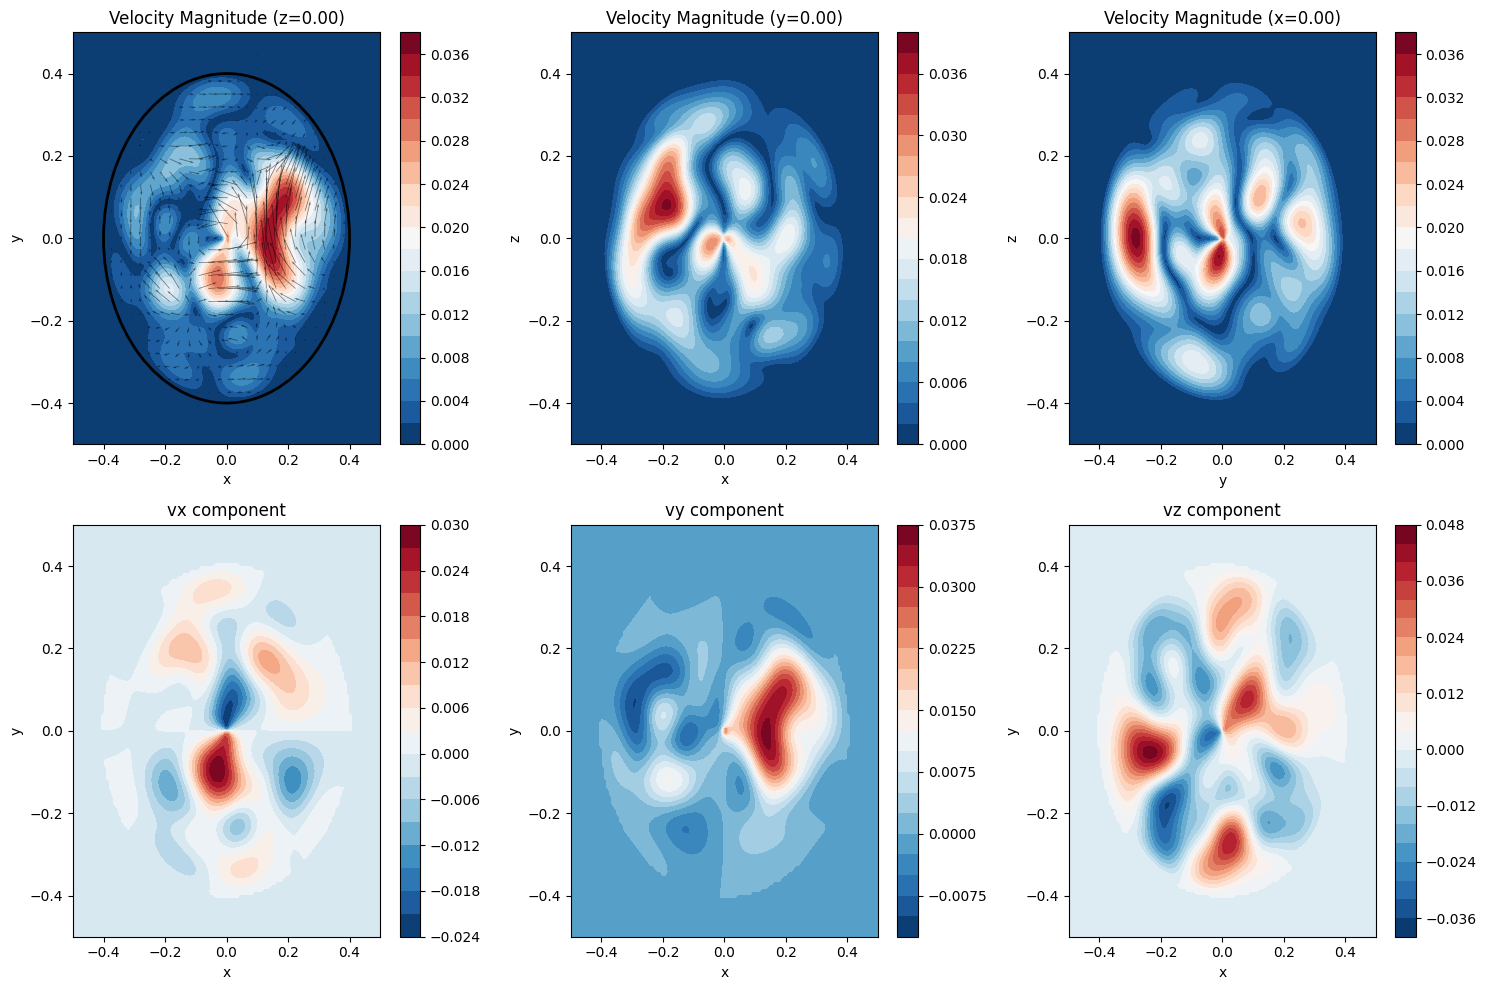

In [29]:
# Now generate a larger field
print("\n\nGenerating larger field (128^3)...")
X, Y, Z, vx, vy, vz = generate_sfb_turbulent_field_fast(
    grid_size=128,
    r0_turb=0.4,
    lmax=10,
    nmax=5,
    kmin=12,
    kmax=50,
    expo=5/3
)

print("\nField statistics:")
vmag = np.sqrt(vx**2 + vy**2 + vz**2)
print(f"Max velocity magnitude: {np.max(vmag):.4f}")
print(f"Mean velocity magnitude: {np.mean(vmag):.4f}")

# Check divergence
print("\nChecking divergence...")
div = check_divergence(X, Y, Z, vx, vy, vz)

# Plot field
print("\nPlotting field slices...")
plot_sfb_field_slice(X, Y, Z, vx, vy, vz)

In [ ]:
# Generate SFB turbulent field using FAST version with improvements
print("Generating SFB turbulent field with Numba acceleration and regularization...")

# Test with 64^3 grid
X, Y, Z, vx, vy, vz = generate_sfb_turbulent_field_fast(
    grid_size=64,
    r0_turb=0.4,
    lmax=10,
    nmax=5,
    kmin=12,
    kmax=50,
    expo=5/3,
    normalize=True  # Remove net momentum and normalize
)

print("\nField statistics:")
R = np.sqrt(X**2 + Y**2 + Z**2)
mask = R < 0.4
vmag = np.sqrt(vx**2 + vy**2 + vz**2)
print(f"Max velocity magnitude: {np.max(vmag[mask]):.4f}")
print(f"Mean velocity magnitude: {np.mean(vmag[mask]):.4f}")
print(f"RMS velocity: {np.sqrt(np.mean(vmag[mask]**2)):.4f}")

# Verify zero net momentum
print(f"\nNet momentum (should be ~0):")
print(f"  <vx> = {np.mean(vx[mask]):.6e}")
print(f"  <vy> = {np.mean(vy[mask]):.6e}")  
print(f"  <vz> = {np.mean(vz[mask]):.6e}")

# Check divergence
print("\nChecking divergence...")
div = check_divergence(X, Y, Z, vx, vy, vz)

# Plot field
print("\nPlotting field slices...")
plot_sfb_field_slice(X, Y, Z, vx, vy, vz)

In [ ]:
# Test with larger grid to check for divergence issues
print("Testing with 256^3 grid to check regularization...")

# Generate field
X_large, Y_large, Z_large, vx_large, vy_large, vz_large = generate_sfb_turbulent_field_fast(
    grid_size=256,
    r0_turb=0.4,
    lmax=12,
    nmax=6,
    kmin=12,
    kmax=50,
    expo=5/3,
    normalize=True  # This will remove net momentum and normalize
)

# Check statistics
R_large = np.sqrt(X_large**2 + Y_large**2 + Z_large**2)
mask = R_large < 0.4
vmag_large = np.sqrt(vx_large**2 + vy_large**2 + vz_large**2)

print("\nField statistics inside r0_turb:")
print(f"Max velocity magnitude: {np.max(vmag_large[mask]):.4f}")
print(f"Mean velocity magnitude: {np.mean(vmag_large[mask]):.4f}")
print(f"RMS velocity: {np.sqrt(np.mean(vmag_large[mask]**2)):.4f}")

# Check net momentum
print(f"\nNet momentum (should be ~0):")
print(f"  <vx> = {np.mean(vx_large[mask]):.6f}")
print(f"  <vy> = {np.mean(vy_large[mask]):.6f}")
print(f"  <vz> = {np.mean(vz_large[mask]):.6f}")

# Check behavior near origin
center_idx = 128
r_center = 5  # Check within 5 grid points of center
center_slice = slice(center_idx-r_center, center_idx+r_center+1)

print(f"\nVelocity near origin (should be regularized):")
vmag_center = vmag_large[center_slice, center_slice, center_slice]
print(f"  Max |v| near r=0: {np.max(vmag_center):.6f}")
print(f"  Mean |v| near r=0: {np.mean(vmag_center):.6f}")

# Plot radial profile
r_bins = np.linspace(0, 0.5, 50)
r_centers = 0.5 * (r_bins[:-1] + r_bins[1:])
vmag_radial = np.zeros_like(r_centers)

for i in range(len(r_centers)):
    mask_r = (R_large.flatten() >= r_bins[i]) & (R_large.flatten() < r_bins[i+1])
    if np.any(mask_r):
        vmag_radial[i] = np.mean(vmag_large.flatten()[mask_r])

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(r_centers, vmag_radial, 'b-', linewidth=2)
plt.axvline(0.4, color='r', linestyle='--', label='r0_turb')
plt.xlabel('r')
plt.ylabel('<|v|>')
plt.title('Radial Profile of Velocity Magnitude')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
# Zoom in near origin
mask_zoom = r_centers < 0.05
plt.plot(r_centers[mask_zoom], vmag_radial[mask_zoom], 'b-', linewidth=2)
plt.xlabel('r')
plt.ylabel('<|v|>')
plt.title('Velocity Near Origin (Zoomed)')
plt.grid(True)

plt.tight_layout()
plt.show()

## 6. Interactive Test

Running quick test with 16x16x16 grid...
Field generated with shape: (16, 16, 16)
Max velocity magnitude: 0.3332
Mean velocity magnitude: 0.0164


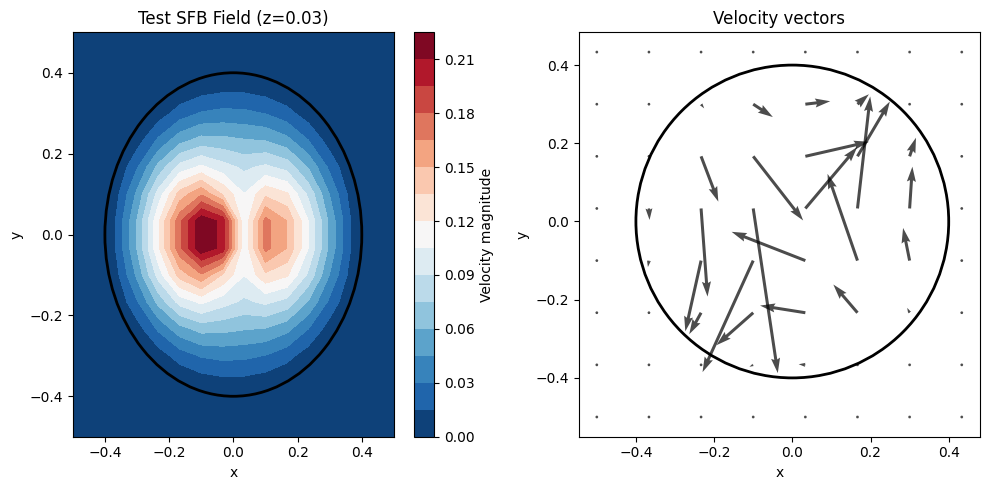

In [24]:
# Quick test with a smaller grid
print("Running quick test with 16x16x16 grid...")

def generate_simple_sfb_field(grid_size=16, r0_turb=0.4):
    """
    Generate a simple SFB velocity field for testing
    """
    # Create small grid
    x = np.linspace(-0.5, 0.5, grid_size)
    X, Y, Z = np.meshgrid(x, x, x, indexing='ij')
    
    # Convert to spherical coordinates
    R = np.sqrt(X**2 + Y**2 + Z**2)
    Theta = np.arccos(np.where(R > 0, Z/R, 1.0))
    Phi = np.arctan2(Y, X)
    
    # Initialize velocity field
    vx = np.zeros_like(X)
    vy = np.zeros_like(Y)
    vz = np.zeros_like(Z)
    
    # Use just a few modes for quick test
    modes_to_test = [
        {'l': 0, 'm': 0, 'n': 1},
        {'l': 1, 'm': 0, 'n': 1},
        {'l': 1, 'm': 1, 'n': 1},
        {'l': 2, 'm': 0, 'n': 1}
    ]
    
    for mode in modes_to_test:
        l = mode['l']
        m = mode['m']
        n = mode['n']
        
        xln = find_spherical_bessel_root(l, n)
        kln = xln / r0_turb
        
        # Random amplitude
        amp = np.random.randn(3) * 0.1
        
        # Add contribution from this mode
        for i in range(grid_size):
            for j in range(grid_size):
                for k in range(grid_size):
                    r = R[i,j,k]
                    if r < r0_turb and r > 0.01:
                        theta = Theta[i,j,k]
                        phi = Phi[i,j,k]
                        
                        B = vector_spherical_harmonic_B(l, m, r, theta, phi, kln)
                        
                        vx[i,j,k] += amp[0] * B[0]
                        vy[i,j,k] += amp[1] * B[1]
                        vz[i,j,k] += amp[2] * B[2]
    
    return X, Y, Z, vx, vy, vz

# Generate field
X_test, Y_test, Z_test, vx_test, vy_test, vz_test = generate_simple_sfb_field()
vmag_test = np.sqrt(vx_test**2 + vy_test**2 + vz_test**2)
print(f"Field generated with shape: {vx_test.shape}")
print(f"Max velocity magnitude: {np.max(vmag_test):.4f}")
print(f"Mean velocity magnitude: {np.mean(vmag_test):.4f}")

# Simple plot
plt.figure(figsize=(10, 5))
slice_idx = Z_test.shape[2] // 2

plt.subplot(1, 2, 1)
vmag_slice = np.sqrt(vx_test[:,:,slice_idx]**2 + vy_test[:,:,slice_idx]**2)
plt.contourf(X_test[:,:,slice_idx], Y_test[:,:,slice_idx], vmag_slice, levels=20, cmap='RdBu_r')
plt.colorbar(label='Velocity magnitude')
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Test SFB Field (z={Z_test[0,0,slice_idx]:.2f})')
circle = plt.Circle((0, 0), 0.4, fill=False, color='black', linewidth=2)
plt.gca().add_patch(circle)

plt.subplot(1, 2, 2)
# Add quiver plot
skip = 2
plt.quiver(X_test[::skip,::skip,slice_idx], Y_test[::skip,::skip,slice_idx],
           vx_test[::skip,::skip,slice_idx], vy_test[::skip,::skip,slice_idx],
           alpha=0.7)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Velocity vectors')
circle = plt.Circle((0, 0), 0.4, fill=False, color='black', linewidth=2)
plt.gca().add_patch(circle)
plt.axis('equal')

plt.tight_layout()
plt.show()

Generating SFB turbulent field...

Field statistics:
Max velocity magnitude: 0.0530
Mean velocity magnitude: 0.0027

Checking divergence...
Max divergence inside r0_turb: 0.849842
Mean |divergence|/|v| inside r0_turb: 18.384194

Plotting field slices...


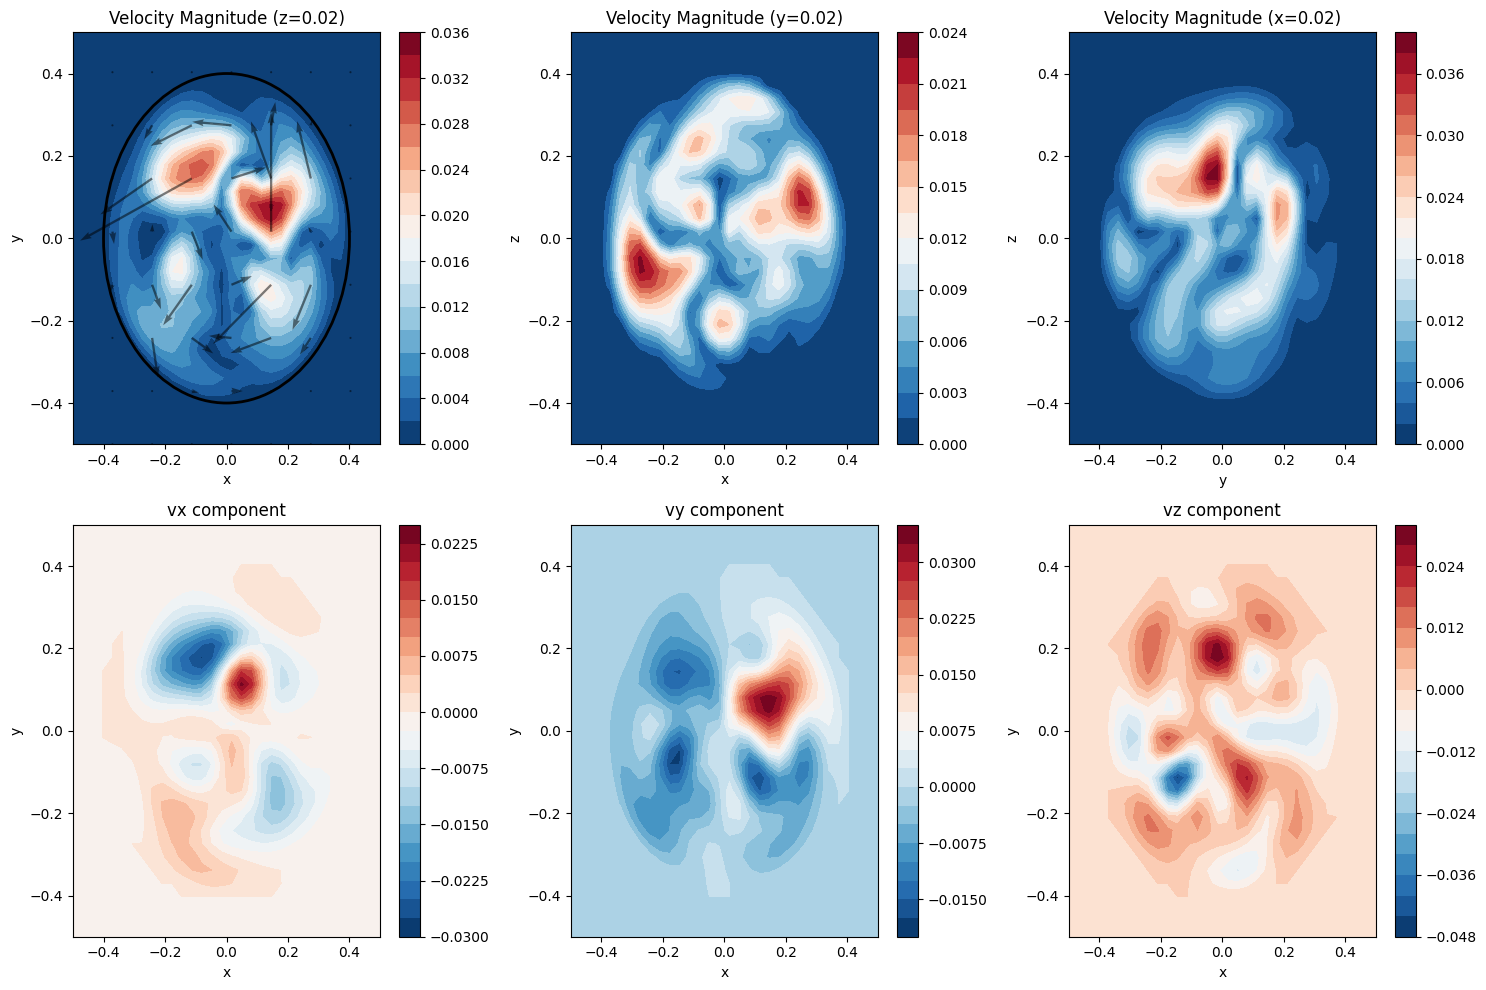

In [25]:
# Generate SFB turbulent field
print("Generating SFB turbulent field...")
X, Y, Z, vx, vy, vz = generate_sfb_turbulent_field(
    grid_size=32,  # Reduced for faster computation
    r0_turb=0.4,
    lmax=8,
    nmax=4,
    kmin=12,
    kmax=50,
    expo=5/3
)

print("\nField statistics:")
vmag = np.sqrt(vx**2 + vy**2 + vz**2)
print(f"Max velocity magnitude: {np.max(vmag):.4f}")
print(f"Mean velocity magnitude: {np.mean(vmag):.4f}")

# Check divergence
print("\nChecking divergence...")
div = check_divergence(X, Y, Z, vx, vy, vz)

# Plot field
print("\nPlotting field slices...")
plot_sfb_field_slice(X, Y, Z, vx, vy, vz)

## 7. Interactive Mode Visualization

In [26]:
def visualize_single_mode(l=1, m=0, n=1, r0_turb=0.4):
    """
    Visualize a single SFB mode
    """
    # Get the root
    xln = find_spherical_bessel_root(l, n)
    kln = xln / r0_turb
    
    # Create grid
    grid_size = 40
    x = np.linspace(-0.5, 0.5, grid_size)
    y = np.linspace(-0.5, 0.5, grid_size)
    z = 0.0  # z-slice
    
    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X**2 + Y**2 + z**2)
    Theta = np.arccos(np.where(R > 0, z/R, 1.0))
    Phi = np.arctan2(Y, X)
    
    # Compute vector field
    vx = np.zeros_like(X)
    vy = np.zeros_like(Y)
    vz = np.zeros_like(X)
    
    for i in range(grid_size):
        for j in range(grid_size):
            r = R[i,j]
            if r < r0_turb and r > 0.01:
                theta = Theta[i,j]
                phi = Phi[i,j]
                B = vector_spherical_harmonic_B(l, m, r, theta, phi, kln)
                vx[i,j] = B[0]
                vy[i,j] = B[1]
                vz[i,j] = B[2]
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Velocity magnitude
    vmag = np.sqrt(vx**2 + vy**2)
    im = ax1.contourf(X, Y, vmag, levels=20, cmap='RdBu_r')
    ax1.set_title(f'Mode (l={l}, m={m}, n={n}), k={kln:.3f}')
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    plt.colorbar(im, ax=ax1)
    
    # Add quiver plot
    skip = 3
    ax1.quiver(X[::skip,::skip], Y[::skip,::skip],
               vx[::skip,::skip], vy[::skip,::skip],
               alpha=0.7, scale=None)
    
    # Draw circle
    circle = plt.Circle((0, 0), r0_turb, fill=False, color='black', linewidth=2)
    ax1.add_patch(circle)
    
    # Radial profile
    r_prof = np.linspace(0, 0.5, 100)
    jl_prof = [spherical_jn(l, kln*r) if r < r0_turb else 0 for r in r_prof]
    ax2.plot(r_prof, jl_prof, 'b-', linewidth=2)
    ax2.axvline(r0_turb, color='black', linestyle='--', label='r0_turb')
    ax2.set_xlabel('r')
    ax2.set_ylabel(f'j_{l}(k_{{{l}{n}}} r)')
    ax2.set_title(f'Radial Profile')
    ax2.grid(True)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Interactive widget
@widgets.interact(l=(0, 5, 1), m=(-5, 5, 1), n=(1, 3, 1))
def interactive_mode(l=1, m=0, n=1):
    if abs(m) <= l:
        visualize_single_mode(l, m, n)
    else:
        print(f"Invalid m={m} for l={l}. Must have |m| <= l")

interactive(children=(IntSlider(value=1, description='l', max=5), IntSlider(value=0, description='m', max=5, m…

## 8. Power Spectrum Analysis



Generating larger field (128^3)...
Generating 512^3 grid with SFB turbulence...
Using 290 modes
Field generation took 120.48 seconds


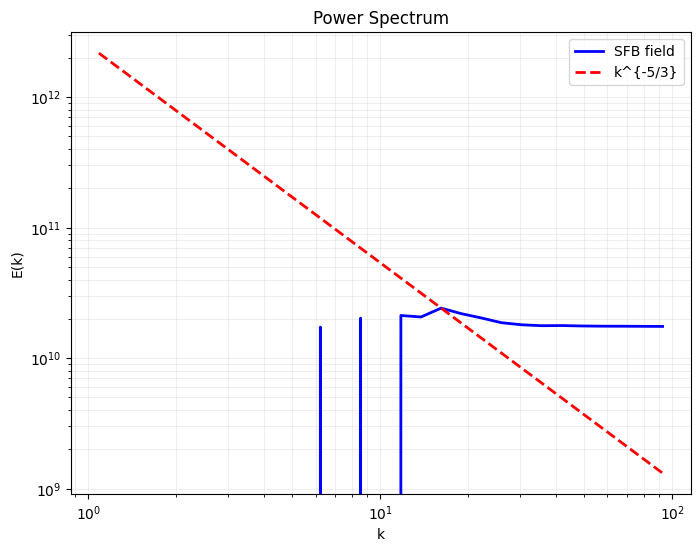

In [33]:
def compute_power_spectrum(vx, vy, vz, dx):
    """
    Compute power spectrum of the velocity field
    """
    # Compute FFT
    vx_fft = np.fft.fftn(vx)
    vy_fft = np.fft.fftn(vy)
    vz_fft = np.fft.fftn(vz)
    
    # Power spectrum
    power = np.abs(vx_fft)**2 + np.abs(vy_fft)**2 + np.abs(vz_fft)**2
    
    # Get wavenumbers
    nx = vx.shape[0]
    kx = np.fft.fftfreq(nx, d=dx) * 2 * np.pi
    
    # Create k grid
    kx_grid, ky_grid, kz_grid = np.meshgrid(kx, kx, kx, indexing='ij')
    k_mag = np.sqrt(kx_grid**2 + ky_grid**2 + kz_grid**2)
    
    # Bin by k magnitude
    k_bins = np.logspace(0, 2, 30)
    k_centers = 0.5 * (k_bins[:-1] + k_bins[1:])
    power_spectrum = np.zeros(len(k_centers))
    
    for i in range(len(k_centers)):
        mask = (k_mag >= k_bins[i]) & (k_mag < k_bins[i+1])
        if np.any(mask):
            power_spectrum[i] = np.mean(power[mask])
    
    return k_centers, power_spectrum


# Now generate a larger field
print("\n\nGenerating larger field (128^3)...")
X, Y, Z, vx, vy, vz = generate_sfb_turbulent_field_fast(
    grid_size=512,
    r0_turb=0.4,
    lmax=10,
    nmax=5,
    kmin=12,
    kmax=50,
    expo=5/3
)

# Compute and plot power spectrum
dx = X[1,0,0] - X[0,0,0]
k_centers, power_spectrum = compute_power_spectrum(vx, vy, vz, dx)

plt.figure(figsize=(8, 6))
plt.loglog(k_centers, power_spectrum, 'b-', linewidth=2, label='SFB field')
plt.loglog(k_centers, power_spectrum[np.argmax(power_spectrum)] * (k_centers/k_centers[np.argmax(power_spectrum)])**(-5/3), 'r--', linewidth=2, label='k^{-5/3}')
plt.xlabel('k')
plt.ylabel('E(k)')
plt.title('Power Spectrum')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.show()



Generating larger field (128^3)...
Generating 256^3 grid with SFB turbulence...
Using 217 modes
Field generation took 11.50 seconds


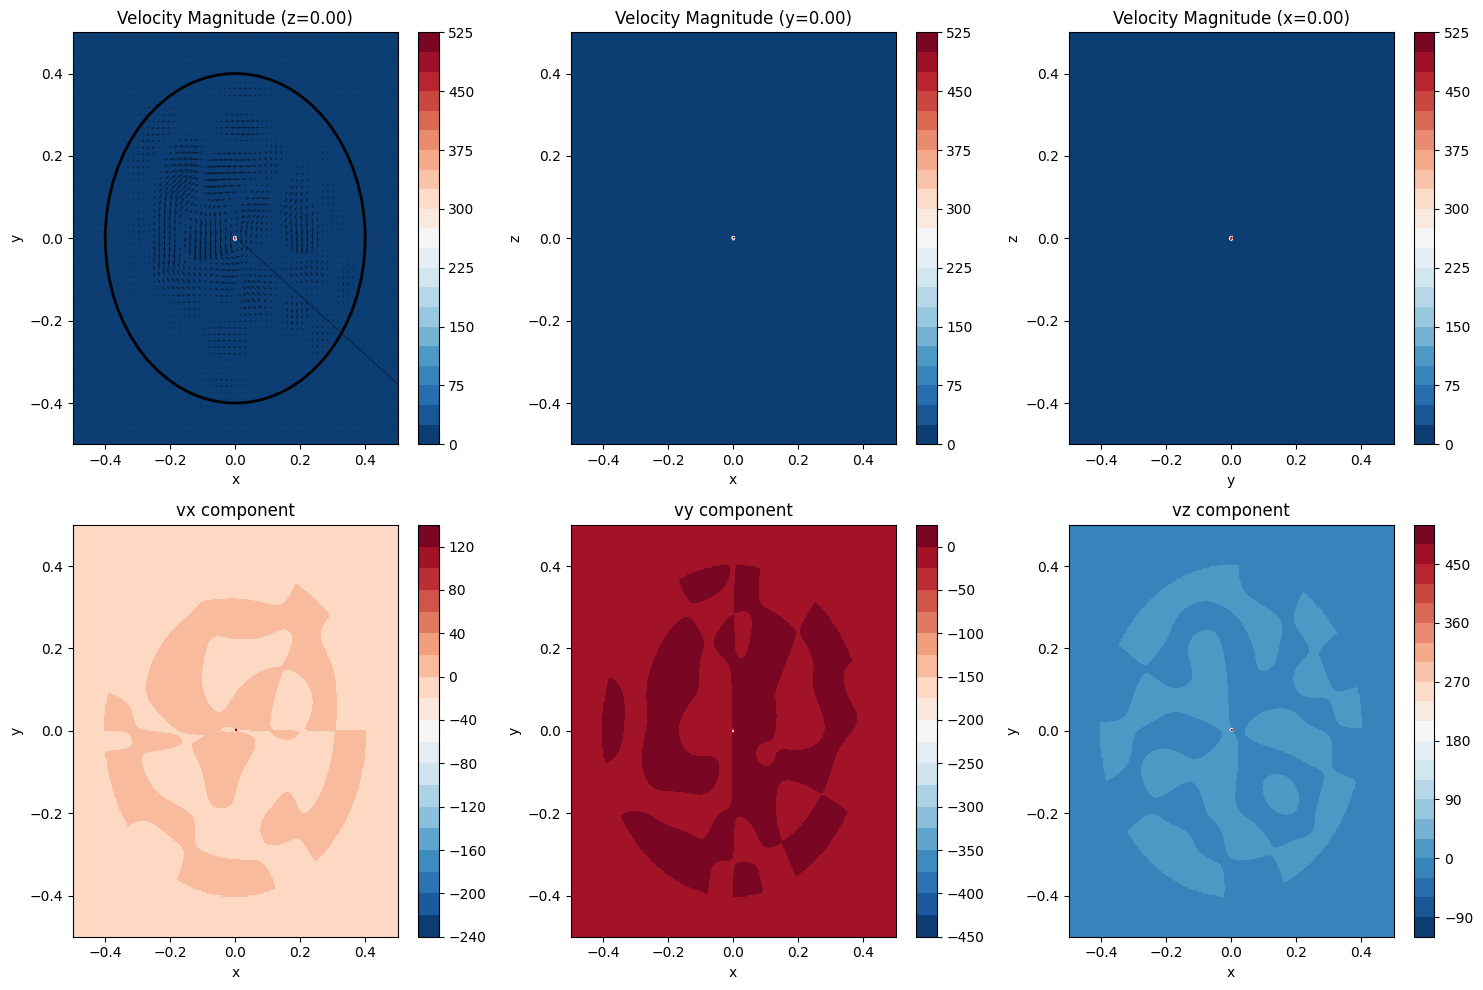

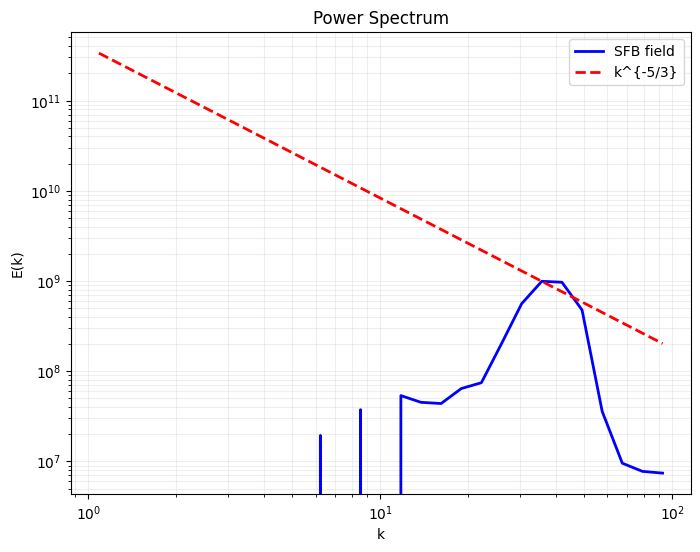

In [46]:
# Now generate a larger field
print("\n\nGenerating larger field (128^3)...")
X, Y, Z, vx, vy, vz = generate_sfb_turbulent_field_fast(
    grid_size=256,
    r0_turb=0.4,
    lmax=10,
    nmax=6,
    kmin=30,
    kmax=50,
    expo=0
)

plot_sfb_field_slice(X, Y, Z, vx, vy, vz)


# Compute and plot power spectrum
dx = X[1,0,0] - X[0,0,0]
k_centers, power_spectrum = compute_power_spectrum(vx, vy, vz, dx)

plt.figure(figsize=(8, 6))
plt.loglog(k_centers, power_spectrum, 'b-', linewidth=2, label='SFB field')
plt.loglog(k_centers, power_spectrum[np.argmax(power_spectrum)] * (k_centers/k_centers[np.argmax(power_spectrum)])**(-5/3), 'r--', linewidth=2, label='k^{-5/3}')
plt.xlabel('k')
plt.ylabel('E(k)')
plt.title('Power Spectrum')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.show()

## Summary

This notebook demonstrates the Spherical Fourier-Bessel turbulence driving implementation:

1. **Mode Selection**: Efficiently selects SFB modes within a specified wavenumber range
2. **Divergence-Free Fields**: Uses vector spherical harmonics to ensure div(v) = 0
3. **Radial Cutoff**: Forcing is confined to r < r0_turb
4. **Power Spectrum Control**: Follows the specified power law (e.g., k^{-5/3})

The implementation is suitable for driving turbulence in spherical geometries with AMR, focusing energy injection in the central region while maintaining physical properties of the turbulent field.